In [1]:
import numpy
from matplotlib import pyplot
import py_monte_carlo
import scipy.sparse
import scipy.linalg

In [2]:
def make_lattice(xsidelen=1, ysidelen=1):
    x = numpy.arange(xsidelen)
    y = numpy.arange(ysidelen)
    n = numpy.arange(4)
    X, Y, N = numpy.meshgrid(x, y, n)

    INDX = Y*len(x)*len(n) + X*len(n) + N
    SQR_BONDS = Y*len(x)*len(n) + X*len(n) + (N + 1)%len(n)

    edges = [((a, b), 1 if a%len(n) == 0 and b%len(n) == 1 else -1) 
             for a,b in zip(INDX.flatten(), SQR_BONDS.flatten())]
    
    for (sx, sy, sn) in zip(X.flatten(), Y.flatten(), N.flatten()):
        if sn == 1:
            a = sy*len(x)*len(n) + sx*len(n) + 1
            b = sy*len(x)*len(n) + ((sx+1)%len(x))*len(n) + 3
            edges.append(((a,b), -1))
        if sn == 0:
            a = sy*len(x)*len(n) + sx*len(n) + 0
            b = ((sy+1)%len(y))*len(x)*len(n) + sx*len(n) + 2
            edges.append(((a,b), -1))
    
    return edges

In [3]:
def make_ham_and_spin(nvars, edges, transverse):
    ham = numpy.zeros((2**nvars,2**nvars))
    for i in range(2**nvars):
        state = [(i >> j) & 1 for j in range(nvars)]
        h = 0.0
        for (vara, varb), j in edges:
            if state[vara] == state[varb]:
                h += j
            else:
                h -= j

        ham[i,i] += h
        for j in range(i+1, 2**nvars):
            b_state = [(j >> k) & 1 for k in range(nvars)]
            diffstate = [a^b for a,b in zip(state, b_state)]
            if sum(diffstate) != 1:
                continue
            for vark,s in enumerate(diffstate):
                if not s:
                    continue
                ham[i, j] = ham[i,j] + transverse
                ham[j, i] = ham[j,i] + transverse

    spin_diag = []
    for i in range(2**nvars):
        state = [(i >> j) & 1 for j in range(nvars)]
        spin_diag.append(numpy.sum(numpy.asarray(state)*2 - 1)**2)
    spin_op = numpy.diag(spin_diag)
    return ham, spin_op

In [4]:
def make_generic(edges, transverse, experiments=4):
    all_vars = list(sorted(set(v for (vs, _) in edges for v in vs)))
    nvars = max(all_vars)+1
    qmc = py_monte_carlo.QMCRunner(nvars, experiments)
    for (a, b), j in edges:
        diag = [
            -j, # 00
            j,  # 01
            j,  # 10
            -j, # 11
        ]
        qmc.add_diagonal_interaction_and_offset(diag, [a, b])
    for a in all_vars:
        qmc.add_interaction([transverse]*4, [a])
    return qmc
    

def make_48_cluster(transverse, xsidelen=1, ysidelen=1, experiments=4):
    nvars = xsidelen*xsidelen*4
    qmc = py_monte_carlo.QMCRunner(nvars, experiments)
    
    def var_lookup(x, y, r):
        return (y%ysidelen)*xsidelen*4 + (x%xsidelen)*4 + (r%4)
    
    for y in range(ysidelen):
        for x in range(xsidelen):
            diag = [
                -2, # 0000
                -2, # 0001
                -2, # 0010
                2,  # 0011
                2,  # 0100
                2,  # 0101
                -2, # 0110
                2,  # 0111
                # --------
                2,  # 1000
                -2, # 1001
                2,  # 1010
                2,  # 1011
                2,  # 1100
                -2, # 1101
                -2, # 1110
                -2, # 1111
            ]
            int_vars = [var_lookup(x, y, r) for r in range(4)]
            qmc.add_diagonal_interaction_and_offset(diag, int_vars)
            
            diag = [
                -1, # 00
                1,  # 01
                1,  # 10
                -1, # 11
            ]
            int_vars = [var_lookup(x, y, 1), var_lookup(x+1, y, 3)]
            qmc.add_diagonal_interaction_and_offset(diag, int_vars)
            int_vars = [var_lookup(x, y, 0), var_lookup(x, y+1, 2)]
            qmc.add_diagonal_interaction_and_offset(diag, int_vars)
            
            # Transverse field
            for r in range(4):
                qmc.add_interaction([transverse]*4, [var_lookup(x, y, r)])
    return qmc

## Test Things

In [5]:
edges =  make_lattice()
transverse = 1.0

lattice_graph = py_monte_carlo.Lattice(edges)
lattice_graph.set_transverse_field(transverse)
print(lattice_graph.get_offset())

generic_graph = make_generic(edges, transverse)
print(generic_graph.get_offset())

cluster_graph = make_48_cluster(transverse)
print(cluster_graph.get_offset())

10.0
6.0
4.0


In [6]:
all_vars = list(sorted(set(v for (vs, _) in edges for v in vs)))
nvars = max(all_vars)+1    
ham, spin_op = make_ham_and_spin(nvars, edges, transverse)
expm = scipy.linalg.expm(-1.0*ham)
numpy.trace(ham @ expm) / numpy.trace(expm)

-4.882318249481541

In [7]:
lattice_graph.run_quantum_monte_carlo_sampling(1.0, 100000, 4)[0]

array([-4.89658, -4.88551, -4.88948, -4.91277])

In [8]:
generic_graph.run_sampling(1.0, 100000)[0]

array([-8.82644, -8.87903, -8.89102, -8.92507])

In [9]:
cluster_graph.run_sampling(1.0, 100000)[0]

array([-8.87421, -8.87653, -8.86574, -8.85895])

## Autocorr

In [10]:
edges = make_lattice(16, 16)
spin_prods = [list(vs) for vs, _ in edges]

1.0
0.5
0.1
0.05


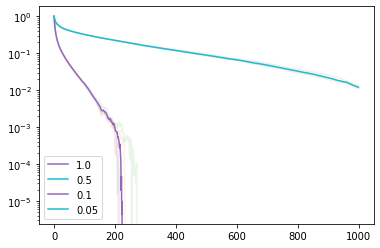

In [11]:
l = py_monte_carlo.Lattice(edges)

for gamma in [1.0, 0.5, 0.1, 0.05]:
    print(gamma)
    l.set_transverse_field(gamma)
    autocorrs = l.run_quantum_monte_carlo_and_measure_spin_product_autocorrelation(2.0, 10000, 4, spin_prods, sampling_wait_buffer=10000)

    for i in range(autocorrs.shape[0]):
        pyplot.plot(autocorrs[i,:1000], alpha=0.1)
    pyplot.plot(numpy.mean(autocorrs[:,:1000], axis=0), label=str(gamma))
pyplot.legend()
pyplot.yscale('log')
pyplot.show()

1.0
0.5
0.1
0.05


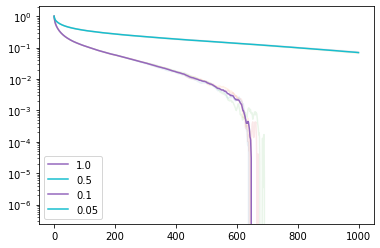

In [13]:
for gamma in [1.0, 0.5, 0.1, 0.05]:
    print(gamma)
    l = make_48_cluster(gamma, 16, 16)
    autocorrs = l.run_quantum_monte_carlo_and_measure_spin_product_autocorrelation(2.0, 10000, spin_prods, sampling_wait_buffer=10000)

    for i in range(autocorrs.shape[0]):
        pyplot.plot(autocorrs[i,:1000], alpha=0.1)
    pyplot.plot(numpy.mean(autocorrs[:,:1000], axis=0), label=str(gamma))
pyplot.legend()
pyplot.yscale('log')
pyplot.show()